<a href="https://colab.research.google.com/github/JuanS286/gif_auto_audio_description/blob/dev/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import imageio
import numpy as np

In [6]:
df = pd.read_csv('tgif-v1.0.tsv', sep='\t', names=['Image', 'Text'])
print(df)

df.head()

                                                    Image  \
0       https://38.media.tumblr.com/9f6c25cc350f12aa74...   
1       https://38.media.tumblr.com/9ead028ef62004ef6a...   
2       https://38.media.tumblr.com/9f43dc410be85b1159...   
3       https://38.media.tumblr.com/9f659499c8754e40cf...   
4       https://38.media.tumblr.com/9ed1c99afa7d714118...   
...                                                   ...   
125777  https://38.media.tumblr.com/5c0633e677a97a023c...   
125778  https://38.media.tumblr.com/402a02c59c7c47c300...   
125779  https://38.media.tumblr.com/02fa66bd747ddbed58...   
125780  https://38.media.tumblr.com/01e70784925ab9fe09...   
125781  https://38.media.tumblr.com/51d2172ef413bc3e88...   

                                                     Text  
0       a man is glaring, and someone with sunglasses ...  
1                a cat tries to catch a mouse on a tablet  
2                        a man dressed in red is dancing.  
3          an animal comes 

,Image,Text
0,https://38.media.tumblr.com/9f6c25cc350f12aa74...,"a man is glaring, and someone with sunglasses ..."
1,https://38.media.tumblr.com/9ead028ef62004ef6a...,a cat tries to catch a mouse on a tablet
2,https://38.media.tumblr.com/9f43dc410be85b1159...,a man dressed in red is dancing.
3,https://38.media.tumblr.com/9f659499c8754e40cf...,an animal comes close to another in the jungle
4,https://38.media.tumblr.com/9ed1c99afa7d714118...,a man in a hat adjusts his tie and makes a wei...


In [7]:
# prompt: preprocessing

import re

def preprocess_text(text):
  """
  Preprocesses the text by converting to lowercase, removing special characters,
  and extra whitespace.
  """
  text = text.lower()
  text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
  text = re.sub(r"\s+", " ", text)
  text = text.strip()
  return text

df['Text'] = df['Text'].apply(preprocess_text)
print(df.head())

                                               Image  \
0  https://38.media.tumblr.com/9f6c25cc350f12aa74...   
1  https://38.media.tumblr.com/9ead028ef62004ef6a...   
2  https://38.media.tumblr.com/9f43dc410be85b1159...   
3  https://38.media.tumblr.com/9f659499c8754e40cf...   
4  https://38.media.tumblr.com/9ed1c99afa7d714118...   

                                                Text  
0  a man is glaring and someone with sunglasses a...  
1           a cat tries to catch a mouse on a tablet  
2                    a man dressed in red is dancing  
3     an animal comes close to another in the jungle  
4  a man in a hat adjusts his tie and makes a wei...  


In [8]:
# prompt: seperate x and y

X = df['Image']
y = df['Text']

In [9]:
# Assuming you have your frame data and corresponding captions in a DataFrame
# Replace this with your actual data loading process
# frame_df should contain 'FramePath' and 'Caption' columns

# Parameters
n_rows=300
vocab_size = 5000
max_length = 30
num_frames_per_video = 10  # Adjust as needed

In [10]:
 # Function to extract frames from GIF
def extract_frames(gif_path, num_frames=10):
    try:
        gif = imageio.mimread(gif_path)
        total_frames = len(gif)
        if total_frames == 0:
            raise ValueError("No frames found in GIF.")
        interval = max(total_frames // num_frames, 1)
        selected_frames = [gif[i] for i in range(0, total_frames, interval)][:num_frames]
        return selected_frames
    except Exception as e:
        print(f"Error extracting frames from {gif_path}: {e}")
        return []

# Example Usage (replace with your actual GIF file paths)

# Assuming your GIF files are in a directory named 'gifs'
import imageio
import os
gif_paths = df['Image'].tolist()  # Assuming your GIF paths are in a column named 'gif_path'

# Function to extract GIF and save frames as image links
def extract_and_save_frames(gif_path, num_frames=10):
    try:
        frames = extract_frames(gif_path, num_frames)
        image_links = []
        for i, frame in enumerate(frames):
            image_filename = f"{os.path.basename(gif_path)}_frame_{i}.png"
            imageio.imwrite(image_filename, frame)  # Save the frame as a PNG file
            image_links.append(image_filename)  # Store the image filename (or URL)
        return image_links
    except Exception as e:
        print(f"Error extracting and saving frames from {gif_path}: {e}")
        return []



In [11]:
# Create a new column in the DataFrame to store image links
new_df= df.iloc[:n_rows].copy()
new_df['Image_Links'] = new_df['Image'].apply(extract_and_save_frames)

new_df.head()


,Image,Text,Image_Links
0,https://38.media.tumblr.com/9f6c25cc350f12aa74...,a man is glaring and someone with sunglasses a...,[tumblr_mevmyaKtDf1rgvhr8o1_500.gif_frame_0.pn...
1,https://38.media.tumblr.com/9ead028ef62004ef6a...,a cat tries to catch a mouse on a tablet,[tumblr_nok4eeONTv1s2yegdo1_400.gif_frame_0.pn...
2,https://38.media.tumblr.com/9f43dc410be85b1159...,a man dressed in red is dancing,[tumblr_mllh01J96X1s9npefo1_250.gif_frame_0.pn...
3,https://38.media.tumblr.com/9f659499c8754e40cf...,an animal comes close to another in the jungle,[tumblr_nqlr0rn8ox1r2r0koo1_400.gif_frame_0.pn...
4,https://38.media.tumblr.com/9ed1c99afa7d714118...,a man in a hat adjusts his tie and makes a wei...,[tumblr_mvtuwlhSkE1qbnleeo1_500.gif_frame_0.pn...


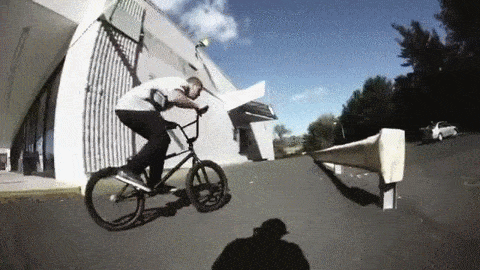

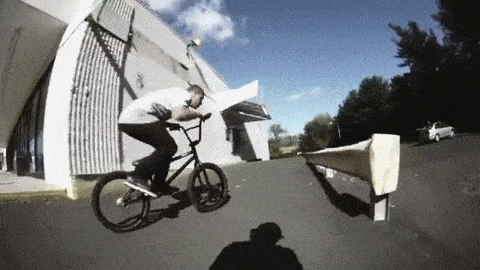

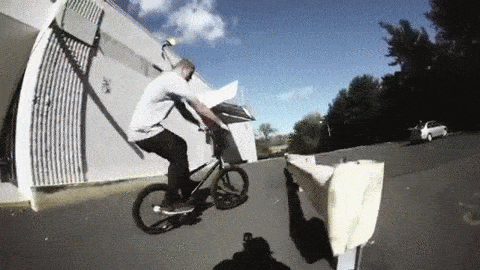

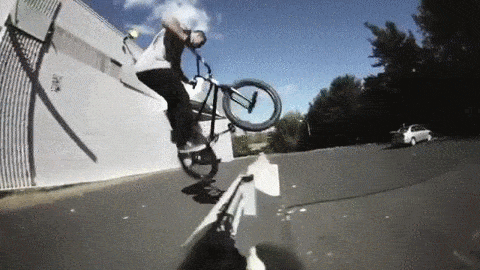

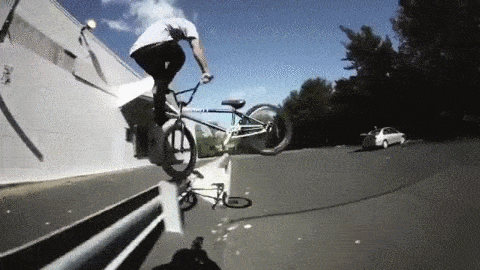

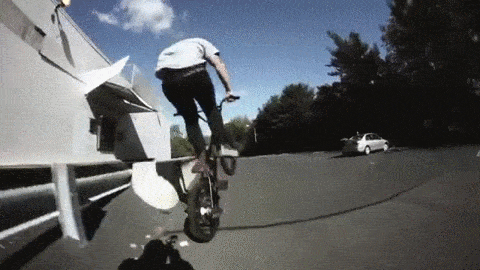

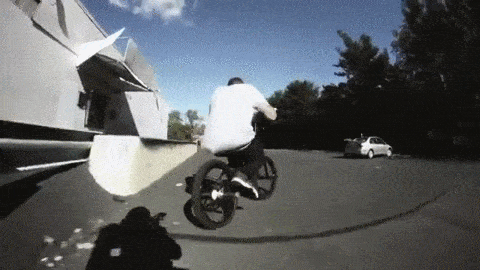

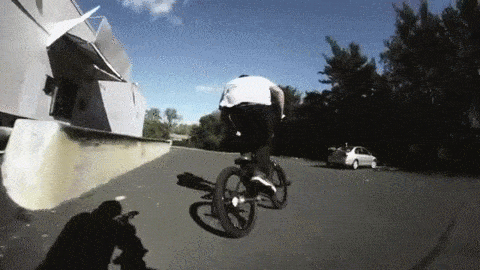

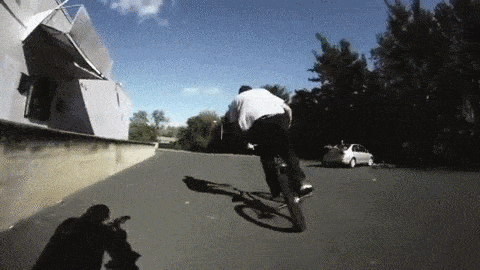

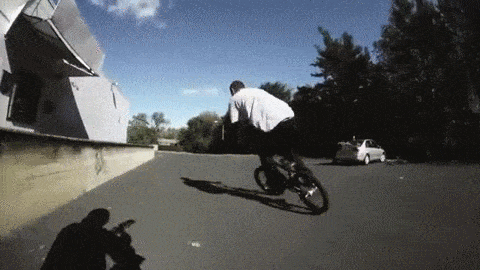

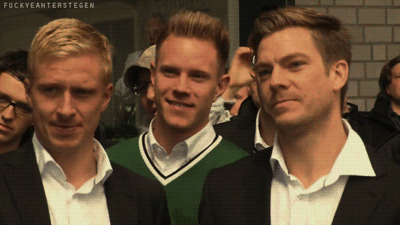

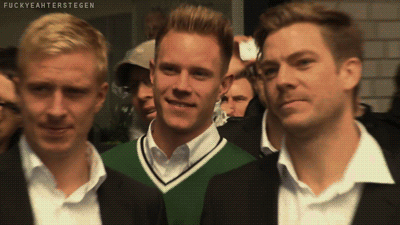

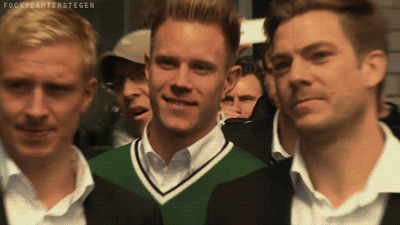

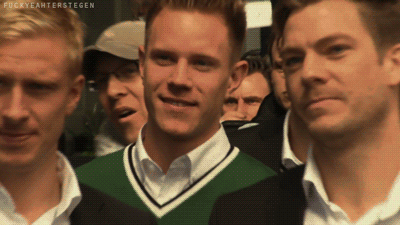

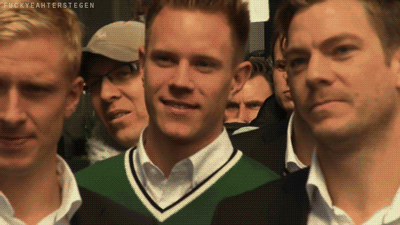

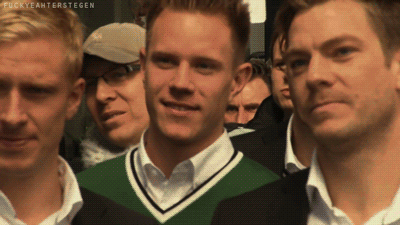

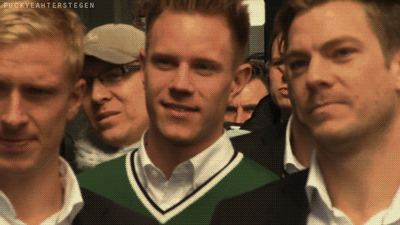

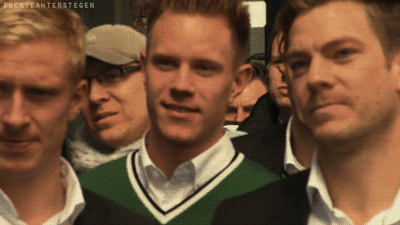

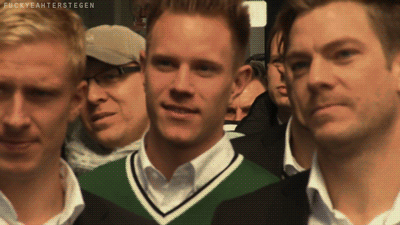

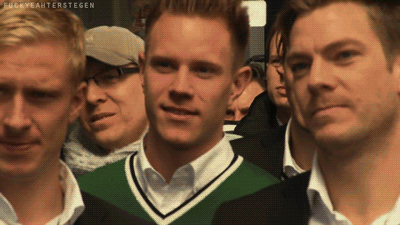

In [12]:
# prompt: open image from image_links

from IPython.display import Image, display

# Assuming you have a DataFrame 'new_df' with 'Image_Links' column
for index, row in new_df[7:9].iterrows():
  if row['Image_Links']:
    for image_link in row['Image_Links']:
      try:
        display(Image(filename=image_link))  # Display the image
      except Exception as e:
        print(f"Error displaying image {image_link}: {e}")



In [13]:
# 1. CNN for Feature Extraction
cnn_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(frame_paths):
  features = []
  for frame_path in frame_paths:
    img = tf.keras.preprocessing.image.load_img(frame_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    feature = cnn_model.predict(img_array)
    features.append(feature)
  return np.array(features).squeeze()

94765736/94765736 [==============================] - 0s 0us/step


In [14]:
# prompt: generate features from new_df for cnn model

# Assuming you have a DataFrame 'new_df' with 'Image_Links' column
cnn_features = []
for index, row in new_df.iterrows():
  if row['Image_Links']:
    features = extract_features(row['Image_Links'])
    cnn_features.append(features)
  else:
    cnn_features.append(None)

new_df['CNN_Features'] = cnn_features


1/1 [==============================] - 0s 78ms/step


In [15]:
new_df

,Image,Text,Image_Links,CNN_Features
0,https://38.media.tumblr.com/9f6c25cc350f12aa74...,a man is glaring and someone with sunglasses a...,[tumblr_mevmyaKtDf1rgvhr8o1_500.gif_frame_0.pn...,"[[0.79883116, 0.1396702, 0.030008333, 4.407206..."
1,https://38.media.tumblr.com/9ead028ef62004ef6a...,a cat tries to catch a mouse on a tablet,[tumblr_nok4eeONTv1s2yegdo1_400.gif_frame_0.pn...,"[[0.32538566, 1.5439769, 0.22353986, 0.0476200..."
2,https://38.media.tumblr.com/9f43dc410be85b1159...,a man dressed in red is dancing,[tumblr_mllh01J96X1s9npefo1_250.gif_frame_0.pn...,"[[0.6446518, 3.4487672, 0.04572263, 3.093665, ..."
3,https://38.media.tumblr.com/9f659499c8754e40cf...,an animal comes close to another in the jungle,[tumblr_nqlr0rn8ox1r2r0koo1_400.gif_frame_0.pn...,"[[0.599273, 1.5209457, 0.4236565, 0.414742, 4...."
4,https://38.media.tumblr.com/9ed1c99afa7d714118...,a man in a hat adjusts his tie and makes a wei...,[tumblr_mvtuwlhSkE1qbnleeo1_500.gif_frame_0.pn...,"[[0.84724224, 0.5047904, 0.17903449, 0.8817683..."
...,...,...,...,...
295,https://38.media.tumblr.com/aec7c37c218f55e500...,two teenagers are talking and laughing about s...,[tumblr_nnzllt1GNO1uuauelo1_500.gif_frame_0.pn...,"[[0.39222935, 0.7601222, 0.28566352, 0.6154637..."
296,https://38.media.tumblr.com/aeae671e3dc7d568a8...,a man twirls a woman and they hug,[tumblr_np9cywDjMg1u32ccdo1_500.gif_frame_0.pn...,"[[3.038526, 0.17117272, 0.72358704, 0.03494032..."
297,https://38.media.tumblr.com/aec9acf8b141617800...,the asian female girl with the dark hair is si...,[tumblr_n7eq61V9yM1r4wzs9o1_500.gif_frame_0.pn...,"[[1.0028442, 0.30026776, 0.053907406, 2.273947..."
298,https://38.media.tumblr.com/aee82fc6c2df07c415...,a man and a woman is kissing in the dark,[tumblr_npe6ffoAqp1tpbbmfo1_500.gif_frame_0.pn...,"[[2.9846323, 0.0, 0.39160132, 1.138152, 0.4751..."


In [16]:
# prompt: split cnn features as x and text as y

X = new_df['CNN_Features']
y = new_df['Text']
# 2. Prepare Captions
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
captions = new_df['Text'].iloc[:n_rows].tolist()
tokenizer.fit_on_texts(captions)
sequences = tokenizer.texts_to_sequences(captions)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
padded_sequences.shape



(300, 30)

In [17]:
# prompt: train_test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, padded_sequences, test_size=0.2, random_state=42)


In [18]:
X_train.head()

,CNN_Features
232,"[[0.19208603, 2.8662426, 0.12926404, 0.3699667..."
59,"[[0.60833335, 1.4512783, 0.0, 1.1247699, 0.531..."
6,"[[1.393128, 1.1050501, 0.0, 2.4332488, 0.79429..."
185,"[[0.078282915, 0.004422718, 0.008085097, 6.370..."
173,"[[1.6678336, 0.4246201, 0.67824477, 0.3996799,..."


In [ ]:

# X_train = np.array([x for x in X_train]) # Convert X_train to a numpy array of CNN features
# X_test = np.array([x for x in X_test]) # Convert X_test to a numpy array of CNN features
y_train = to_categorical(y_train, num_classes=vocab_size)
y_test = to_categorical(y_test, num_classes=vocab_size)

In [22]:
# need to change
X = np.array([np.array(x) for x in new_df['CNN_Features'].tolist()]) # Convert each element to a NumPy array
y = padded_sequences
from tensorflow.keras.utils import to_categorical

y_ = to_categorical(y, num_classes=num_decoder_tokens)

X.shape, y.shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (300,) + inhomogeneous part.

In [24]:
"""
time_steps_encoder is the number of frames per video we will be using for training
num_encoder_tokens is the number of features from each frame
latent_dim is the number of hidden features for lstm
time_steps_decoder is the maximum length of each sentence
num_decoder_tokens is the final number of tokens in the softmax layer
batch size
"""
time_steps_encoder=X.shape[1]
num_encoder_tokens=X.shape[2]
latent_dim=512
time_steps_decoder=30
num_decoder_tokens=1500
batch_size=320

encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")
encoder = LSTM(latent_dim, return_state=True,return_sequences=True, name='endcoder_lstm')
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


# Set up the decoder
decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name= "decoder_inputs")
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_relu')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

IndexError: tuple index out of range

In [ ]:
# prompt: fit the model

# Assuming you have your training data prepared as X_train_features and y_train_captions
# Train the model
model.fit(
    x=[X, y],
    y=y,
    epochs=10,  # Adjust the number of epochs
    batch_size=32
)

In [ ]:
# prompt: evalute the model

loss = model.evaluate(
    x=[X, y],
    y=y,
    verbose=0
)

print("Evaluation Loss:", loss)


In [ ]:
# prompt: calculate bleu rouge bert score

import numpy as np
!pip install rouge_score
!pip install bert_score

from rouge_score import rouge_scorer
from bert_score import score

def calculate_scores(references, predictions):
  """
  Calculates BLEU, ROUGE, and BERT scores.

  Args:
    references: A list of reference captions.
    predictions: A list of predicted captions.

  Returns:
    A dictionary containing BLEU, ROUGE, and BERT scores.
  """
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  rouge_scores = [scorer.score(ref, pred) for ref, pred in zip(references, predictions)]
  avg_rouge1 = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
  avg_rouge2 = np.mean([score['rouge2'].fmeasure for score in rouge_scores])
  avg_rougeL = np.mean([score['rougeL'].fmeasure for score in rouge_scores])

  P, R, F1 = score(predictions, references, lang="en", rescale_with_baseline=True)
  avg_bert_f1 = F1.mean().item()


  return {
      'ROUGE-1': avg_rouge1,
      'ROUGE-2': avg_rouge2,
      'ROUGE-L': avg_rougeL,
      'BERT-F1': avg_bert_f1,
  }

# Example usage:
# Assuming you have your model's predictions and the ground truth captions
references = new_df['Text'].iloc[:10].tolist()
# Replace this with your model's predicted captions
predictions = ['This is a predicted caption.', 'Another predicted caption.'] * 5 # Replace with actual predictions

# The original code multiplied the list by 10, resulting in a list of length 20
# Changed to multiply by 5 to match the length of references (10)

scores = calculate_scores(references, predictions)
print(scores)
